#### pt3: exploring effect of pp number (data#) on performance, to assess if we are overfitting when spliting non group wise

using only stat typing features (and all facial features)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pykalman import KalmanFilter
import os


In [2]:

dir_in = 'D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSensors_allPPs'
os.chdir(dir_in)
# df = pd.read_csv('all_data_FINAL.csv')

df = pd.read_csv('all_data_final_kalmanFilled.csv')

In [3]:
#all features
num_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'duration', 'Rclick', 'Lclick', 'move_dist', 'move_duration', 'move_speed',
 'scroll_dur', 'keyPress', 'press_dur', 'backsp', 'backsp_dur', 'pause_dur', 'pause_rate']

#stat significant typing features+all facial features
feature_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'Rclick', 'Lclick', 'keyPress', 'move_dist','move_duration']

# feature_cols = num_cols

In [4]:
from sklearn.model_selection import train_test_split ,cross_val_score,RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## splitting group wise 

#### (functions)

In [54]:
def split1st_per_group (df, feature_cols):
    x = df[feature_cols] 
    y = df['condition']

    # models = [svm.SVC( random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=41), RandomForestClassifier(random_state=43)]

    # model = models[0]

    PPgroups = df['pp_id'].copy().tolist()

    #initial splitting, this test will be used for final testing. the train will be split further in CV
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
    for train_index, test_index in gss.split(x, y, groups=PPgroups):
        print('a test-train split')
        x_train = x.iloc[train_index, :]
        x_test = x.iloc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        pp_groups_trainOnly = df.iloc[train_index]['pp_id'] #will have one(or some) pp less than PPgroups!
        print('done splitting')
        print('train: '+ str(set(df.iloc[train_index]['pp_id'])))
        print('test: '+ str(set(df.iloc[test_index]['pp_id'] )))

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    return x_train_scaled, x_test_scaled, PPgroups, y_train, y_test, pp_groups_trainOnly

plotting results function

In [103]:
def plot_tuned_accuracy_per_datasize(len_pp, dt_train_best_acc, dt_train_best_stdev, dt_test_best, title, xaxisrange):
    plt.subplot(111)
    plt.plot(len_pp, dt_train_best_acc, label = 'train')
    plt.fill_between ( x = len_pp, y1 = np.array(dt_train_best_acc) + np.array(dt_train_best_stdev),\
                    y2 = np.array(dt_train_best_acc) - np.array(dt_train_best_stdev), alpha=0.2 )
    plt.plot(len_pp, dt_test_best, label = 'test')
    plt.title(title)
    plt.ylim(xaxisrange[0], xaxisrange[1])
    plt.xlabel('number of participants in dataset')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


#### DT random search tuning + cv on data already split (function)

In [58]:

def tune_cv_dt_groups (x_train_scaled, x_test_scaled, y_train, y_test, pp_groups_trainOnly):
    # i already have x_train, y train (2b used for random search cv) and x test, y test

    params_dt={
        'max_depth': [2, 3, 5, 10, 20, 50, 100, 150, 200, 300, 500],
        'min_samples_leaf': [5, 10, 20, 50, 100, 200, 500],
        'criterion': ["gini", "entropy"]}


    random_search_dt = RandomizedSearchCV(estimator= DecisionTreeClassifier(random_state=41), 
                            param_distributions= params_dt, 
                            n_iter= 100,
                            scoring= ['accuracy'], 
                            refit= 'accuracy', 
                            n_jobs= -1, 
                            cv= GroupKFold(n_splits = 5), 
                            verbose=0,
                            random_state=42)

    # Fit grid search
    random_result_dt = random_search_dt.fit(x_train_scaled, y_train, groups= pp_groups_trainOnly) 

    print(f'DT: The best accuracy score for the training dataset is {random_search_dt.best_score_:.4f}')

    print(f'The best hyperparameters are {random_result_dt.best_params_}')
    # Print the best accuracy score for the testing dataset
    print(f'The accuracy score for the testing dataset is {random_search_dt.score(x_test_scaled, y_test):.4f}') #!!!!!!!!!!!!!!!!!!!!!
    # print('printing results')
    # random_result.cv_results_
    # random_result_rf.cv_results_['params'] #the params used
    best_train_score = random_search_dt.best_score_
    test_best = random_search_dt.score(x_test_scaled, y_test)
    # return random_result_dt , random_search_dt.best_score_, random_search_dt.score(x_test_scaled, y_test)
    return random_result_dt, best_train_score, test_best

#### applying functions to data with different pp numbers

In [67]:
#defining pp ids in dataset
pp_lst = list(set(df['pp_id']))
#storing dt results
dt_train_best_acc = [] ; dt_train_best_stdev=[]; dt_test_best =[] ; len_pp = []

for i in range(7, len(pp_lst)+1): #MIN 7 pps due to (1) 80-20% first split (5 in train 2 in test) and 5fold cv in tuning
    curr_df = df.loc[df['pp_id'].isin(pp_lst[:i])].reset_index() 
    print()
    print('curent data has number of pps: '+ str(len(pp_lst[:i])))
    print(set(curr_df['pp_id']))

    # splitting once
    x_train_scaled_group, x_test_scaled_group, PPgroups, y_train_group, y_test_group, pp_groups_trainOnly = split1st_per_group(curr_df, feature_cols)
    # print('training pps are: '+ str(set(pp_groups_trainOnly)))
    #tuning DT & storing results
    dt_tuning_result, curr_train_best_acc, curr_test_best = tune_cv_dt_groups(x_train_scaled_group, x_test_scaled_group, y_train_group, y_test_group, pp_groups_trainOnly)
    dt_train_best_acc.append(curr_train_best_acc) ; dt_train_best_stdev.append(dt_tuning_result.cv_results_['std_test_accuracy'][dt_tuning_result.best_index_])
    dt_test_best.append(curr_test_best) 
    len_pp.append(len(pp_lst[:i]))
    
    


curent data has number of pps: 7
{'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
a test-train split
done splitting
train: {'pp12', 'pp07', 'pp22', 'pp09', 'pp25'}
test: {'pp24', 'pp17'}
DT: The best accuracy score for the training dataset is 0.6433
The best hyperparameters are {'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.5750

curent data has number of pps: 8
{'pp11', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
a test-train split
done splitting
train: {'pp11', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24'}
test: {'pp25', 'pp12'}
DT: The best accuracy score for the training dataset is 0.5433
The best hyperparameters are {'min_samples_leaf': 20, 'max_depth': 5, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.6083

curent data has number of pps: 9
{'pp11', 'pp13', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
a test-train split
done splitting
train: {'pp11', 'pp13', 'pp07',

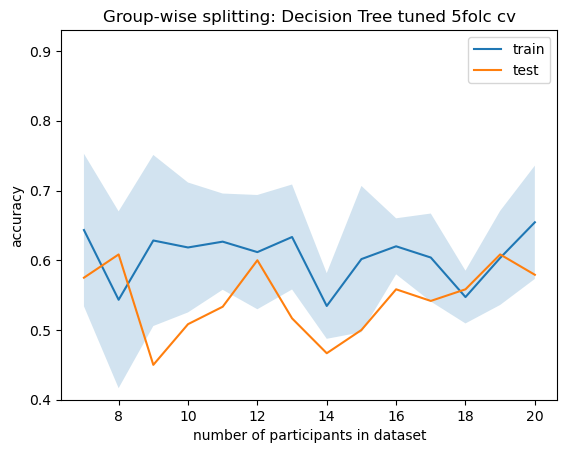

In [113]:
# plotting results

plot_tuned_accuracy_per_datasize(len_pp, dt_train_best_acc, dt_train_best_stdev, dt_test_best, title='Group-wise splitting: Decision Tree tuned 5folc cv', xaxisrange=[0.4,0.93])

## splitting NOT group wise 

#### functions

In [94]:
def split1st_stratisfied_n_scale(df, feature_cols):
    df['stratCol'] = df['pp_id'].astype(str) + "_" + df['condition'].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['condition'], test_size=0.20, stratify=df['stratCol'], random_state=42)

    df.drop('stratCol', axis=1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test
        

In [93]:

def tune_cv_dt_shuffledSplit(x_train_scaled, x_test_scaled, y_train, y_test):
    # i already have x_train, y train (2b used for random search cv) and x test, y test

    params_dt={
        'max_depth': [2, 3, 5, 10, 20, 50, 100, 150, 200, 300, 500],
        'min_samples_leaf': [5, 10, 20, 50, 100, 200, 500],
        'criterion': ["gini", "entropy"]}


    random_search_dt = RandomizedSearchCV(estimator= DecisionTreeClassifier(random_state=41), 
                            param_distributions= params_dt, 
                            n_iter= 100,
                            scoring= ['accuracy'], 
                            refit= 'accuracy', 
                            n_jobs= -1, 
                            cv= 5, 
                            verbose=0,
                            random_state=42)

    # Fit grid search
    random_result_dt = random_search_dt.fit(x_train_scaled, y_train) 

    print(f'DT: The best accuracy score for the training dataset is {random_search_dt.best_score_:.4f}')

    print(f'The best hyperparameters are {random_result_dt.best_params_}')
    # Print the best accuracy score for the testing dataset
    print(f'The accuracy score for the testing dataset is {random_search_dt.score(x_test_scaled, y_test):.4f}') #!!!!!!!!!!!!!!!!!!!!!
    # print('printing results')
    # random_result.cv_results_
    # random_result_rf.cv_results_['params'] #the params used
    best_test_score = random_search_dt.best_score_
    test_best = random_search_dt.score(x_test_scaled, y_test)
    # return random_result_dt , random_search_dt.best_score_, random_search_dt.score(x_test_scaled, y_test)
    return random_result_dt, best_test_score, test_best

#### applying functions to dataset containing different pp numbers

In [95]:
#storing pp ids in full daaset
pp_lst = list(set(df['pp_id']))
#storing dt results
ss_dt_train_best_acc = [] ; ss_dt_train_best_stdev=[]; ss_dt_test_best =[] ; len_pp = []

for i in range(7, len(pp_lst)+1): #MIN 7 pps due to (1) 80-20% first split (5 in train 2 in test) and 5fold cv in tuning--> keeping it the same even if im not splitting per group here
    curr_df = df.loc[df['pp_id'].isin(pp_lst[:i])].reset_index() 
    print()
    print('curent data has number of pps: '+ str(len(pp_lst[:i])))
    print(set(curr_df['pp_id']))

    # splitting once
    x_train_scaled_ss, x_test_scaled_ss,  y_train_ss, y_test_ss = split1st_stratisfied_n_scale(curr_df, feature_cols)
    # print('training pps are: '+ str(set(pp_groups_trainOnly)))
    #tuning DT & storing results
    dt_tuning_result_ss, curr_train_best_acc_ss, curr_test_best_ss = tune_cv_dt_shuffledSplit(x_train_scaled_ss, x_test_scaled_ss, y_train_ss, y_test_ss)

    ss_dt_train_best_acc.append(curr_train_best_acc_ss) ; ss_dt_train_best_stdev.append(dt_tuning_result_ss.cv_results_['std_test_accuracy'][dt_tuning_result_ss.best_index_])
    ss_dt_test_best.append(curr_test_best_ss) 
    len_pp.append(len(pp_lst[:i]))
    
    


curent data has number of pps: 7
{'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
DT: The best accuracy score for the training dataset is 0.8569
The best hyperparameters are {'min_samples_leaf': 5, 'max_depth': 100, 'criterion': 'gini'}
The accuracy score for the testing dataset is 0.8810

curent data has number of pps: 8
{'pp11', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
DT: The best accuracy score for the training dataset is 0.8412
The best hyperparameters are {'min_samples_leaf': 10, 'max_depth': 50, 'criterion': 'gini'}
The accuracy score for the testing dataset is 0.8125

curent data has number of pps: 9
{'pp11', 'pp13', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
DT: The best accuracy score for the training dataset is 0.8149
The best hyperparameters are {'min_samples_leaf': 10, 'max_depth': 50, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.8148

curent data has number of pps: 10
{'pp11', 'pp13', 'pp12', 'pp07', 'pp02', 

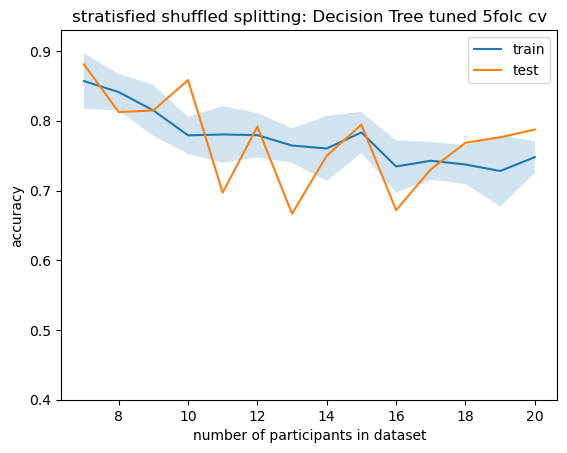

In [112]:
# plotting results

plot_tuned_accuracy_per_datasize(len_pp, ss_dt_train_best_acc, ss_dt_train_best_stdev, ss_dt_test_best, title='stratisfied shuffled splitting: Decision Tree tuned 5folc cv', xaxisrange=[0.4,0.93])

### splitting random shuffled

#### functions

In [107]:
def split1st_n_scale(df, feature_cols):
    # df['stratCol'] = df['pp_id'].astype(str) + "_" + df['condition'].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['condition'], test_size=0.20, random_state=42)

    # df.drop('stratCol', axis=1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test
        

gonna use the same shuffledsplit tuning cv function

#### applying function random shuffled split to dataset with varying pp numbers

In [108]:
#storing pp ids in full daaset
pp_lst = list(set(df['pp_id']))
#storing dt results
rs_dt_train_best_acc = [] ; rs_dt_train_best_stdev=[]; rs_dt_test_best =[] ; len_pp = []

for i in range(7, len(pp_lst)+1): #MIN 7 pps due to (1) 80-20% first split (5 in train 2 in test) and 5fold cv in tuning--> keeping it the same even if im not splitting per group here
    curr_df = df.loc[df['pp_id'].isin(pp_lst[:i])].reset_index() 
    print()
    print('curent data has number of pps: '+ str(len(pp_lst[:i])))
    print(set(curr_df['pp_id']))

    # splitting once
    x_train_scaled_rs, x_test_scaled_rs,  y_train_rs, y_test_rs = split1st_n_scale(curr_df, feature_cols)
    # print('training pps are: '+ str(set(pp_groups_trainOnly)))
    #tuning DT & storing results
    dt_tuning_result_rs, curr_train_best_acc_rs, curr_test_best_rs = tune_cv_dt_shuffledSplit(x_train_scaled_rs, x_test_scaled_rs, y_train_rs, y_test_rs)

    rs_dt_train_best_acc.append(curr_train_best_acc_rs) ; rs_dt_train_best_stdev.append(dt_tuning_result_rs.cv_results_['std_test_accuracy'][dt_tuning_result_rs.best_index_])
    rs_dt_test_best.append(curr_test_best_rs) 
    len_pp.append(len(pp_lst[:i]))
    
    


curent data has number of pps: 7
{'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
DT: The best accuracy score for the training dataset is 0.8395
The best hyperparameters are {'min_samples_leaf': 10, 'max_depth': 50, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.8690

curent data has number of pps: 8
{'pp11', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
DT: The best accuracy score for the training dataset is 0.8517
The best hyperparameters are {'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.8333

curent data has number of pps: 9
{'pp11', 'pp13', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
DT: The best accuracy score for the training dataset is 0.8146
The best hyperparameters are {'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.8426

curent data has number of pps: 10
{'pp11', 'pp13', 'pp12', 'pp07', 'pp0

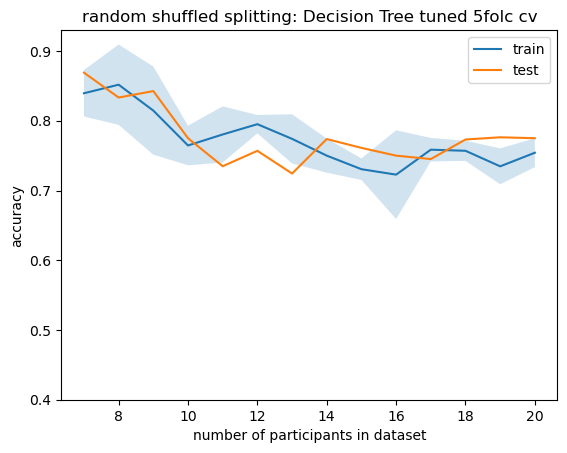

In [111]:
# plotting results

plot_tuned_accuracy_per_datasize(len_pp, rs_dt_train_best_acc, rs_dt_train_best_stdev, rs_dt_test_best, title='random shuffled splitting: Decision Tree tuned 5folc cv', xaxisrange=[0.4,0.93])

### NEW scenario: splitting per group 1st. then in tuning+cv i split randomly. but test with never before seen participants

so will use the function split1st_per_group and then the tune_cv_randomSplitting

In [114]:
#defining pp ids in dataset
pp_lst = list(set(df['pp_id']))
#storing dt results
dt_train_best_acc_split4 = [] ; dt_train_best_stdev_split4=[]; dt_test_best_split4 =[] ; len_pp = []

for i in range(7, len(pp_lst)+1): #MIN 7 pps due to (1) 80-20% first split (5 in train 2 in test) and 5fold cv in tuning
    curr_df = df.loc[df['pp_id'].isin(pp_lst[:i])].reset_index() 
    print()
    print('curent data has number of pps: '+ str(len(pp_lst[:i])))
    print(set(curr_df['pp_id']))

    # splitting once
    x_train_scaled_s4, x_test_scaled_s4, PPgroups, y_train_s4, y_test_s4, pp_groups_trainOnly = split1st_per_group(curr_df, feature_cols)
    
    #tuning DT & storing results
    dt_tuning_result_s4, curr_train_best_acc_s4, curr_test_best_s4 = tune_cv_dt_shuffledSplit(x_train_scaled_s4, x_test_scaled_s4, y_train_s4, y_test_s4)

    dt_train_best_acc_split4.append(curr_train_best_acc_s4) ; dt_train_best_stdev_split4.append(dt_tuning_result_s4.cv_results_['std_test_accuracy'][dt_tuning_result_s4.best_index_])
    dt_test_best_split4.append(curr_test_best_s4) 
    len_pp.append(len(pp_lst[:i]))
    
    


curent data has number of pps: 7
{'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
a test-train split
done splitting
train: {'pp12', 'pp07', 'pp22', 'pp09', 'pp25'}
test: {'pp24', 'pp17'}
DT: The best accuracy score for the training dataset is 0.6433
The best hyperparameters are {'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.5750

curent data has number of pps: 8
{'pp11', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
a test-train split
done splitting
train: {'pp11', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24'}
test: {'pp25', 'pp12'}
DT: The best accuracy score for the training dataset is 0.6667
The best hyperparameters are {'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.6000

curent data has number of pps: 9
{'pp11', 'pp13', 'pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25'}
a test-train split
done splitting
train: {'pp11', 'pp13', 'pp07',

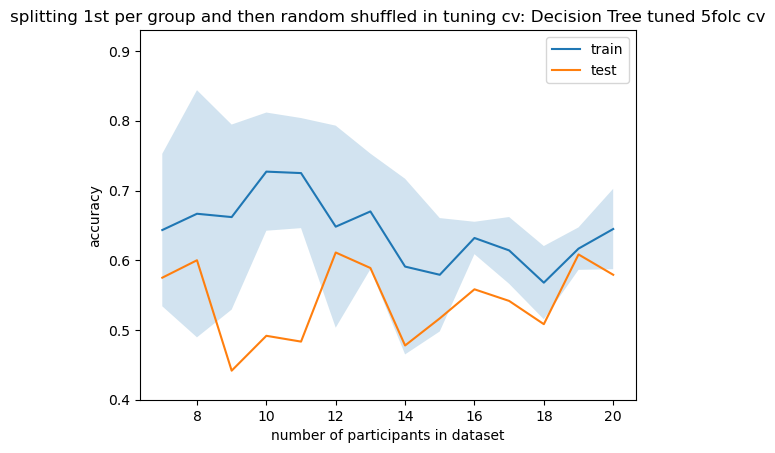

In [115]:
# plotting results

plot_tuned_accuracy_per_datasize(len_pp, dt_train_best_acc_split4, dt_train_best_stdev_split4, dt_test_best_split4, title='splitting 1st per group and then random shuffled in tuning cv: Decision Tree tuned 5folc cv', xaxisrange=[0.4,0.93])

debugging 6 pps

In [37]:
# curr_df = df.loc[df['pp_id'].isin(pp_lst[:6])].reset_index() 

In [38]:
# curr_df.index

RangeIndex(start=0, stop=360, step=1)

In [39]:
# x = curr_df[feature_cols] 
# y = curr_df['condition']

# # models = [svm.SVC( random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=41), RandomForestClassifier(random_state=43)]

# # model = models[0]

# PPgroups = curr_df['pp_id'].copy().tolist()

# #initial splitting, this test will be used for final testing. the train will be split further in CV
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
# for train_index, test_index in gss.split(x, y, groups=PPgroups):
#     print('a test-train split')
#     x_train = x.iloc[train_index, :]
#     x_test = x.iloc[test_index, :]
#     y_train = y[train_index]
#     y_test = y[test_index]
#     pp_groups_trainOnly = df.iloc[train_index]['pp_id'] #will have one(or some) pp less than PPgroups!
#     print('done splitting')

a test-train split
done splitting


5fold cv, so min pps in x_train_scaled: 5. so total min pps 6 kai PROXEIRO

In [17]:
pp_lst = list(set(df['pp_id']))
print(pp_lst)

for i in range(6, len(pp_lst)+1): #MIN 6 pps due to 5fold cv in tuning
    print(pp_lst[:i])
 #2select them from df   
d2 = df.loc[df['pp_id'].isin(pp_lst[:6])]
set(d2['pp_id'])

['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13', 'pp02']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13', 'pp02', 'pp15']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13', 'pp02', 'pp15', 'pp19']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13', 'pp02', 'pp15', 'pp19', 'pp23']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13', 'pp02', 'pp15', 'pp19', 'pp23', 'pp26']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13', 'pp02', 'pp15', 'pp19', 'pp23', 'pp26', 'pp03']
['pp12', 'pp07', 'pp17', 'pp22', 'pp09', 'pp24', 'pp25', 'pp11', 'pp13', 'pp02', 'pp15', 'pp19', 'pp23', 'pp26', 'pp03', 'pp06']
['pp12', 'pp07', 'pp1

In [27]:
d2 = df.loc[df['pp_id'].isin(pp_lst[:6])]
set(d2['pp_id'])
d2.head()

,pp_id,condition,ts(sec),frame,success,confidence,AU1_InnerBrowRaiser,AU2_OuterBrowRaiser,AU4_BrowLowerer,AU5_UpperLipRaiser,...,move_dist,move_duration,move_speed,scroll_dur,keyPress,press_dur,backsp,backsp_dur,pause_dur,pause_rate
300,pp07,N,60.103,1800.0,0.998889,0.912317,0.289282,0.330887,0.231281,0.040885,...,8.106782,0.026887,981.141985,0.268320,66.282958,0.313386,66.282958,0.112479,0.750741,1.251016
301,pp07,N,120.239,3600.0,1.000000,0.917461,0.252920,0.201771,0.178906,0.073482,...,9.448963,0.024185,1138.867978,0.326374,60.359881,0.187058,60.359881,0.140828,2.150243,3.557758
302,pp07,N,180.376,5400.0,1.000000,0.946833,0.138182,0.069211,0.105143,0.067306,...,8.961475,0.020599,1095.495310,0.372621,70.009545,0.268600,70.009545,0.075397,1.725347,2.868920
303,pp07,N,240.512,7200.0,1.000000,0.934250,0.102032,0.027045,0.071478,0.045539,...,8.961475,0.020599,1095.495310,0.372621,92.746979,0.291549,92.746979,0.050242,1.181320,1.974823
304,pp07,N,300.648,9000.0,1.000000,0.920778,0.088916,0.014004,0.040006,0.040336,...,8.961475,0.020599,1095.495310,0.372621,92.859805,0.319961,92.859805,0.032096,0.942588,1.578686


## maybe low accuracy cause gold labels are wrong? redoin analysis k model comparison with only the last 15 mins of each pp

In [21]:
d2 = df.loc[df['ts(sec)']>900].copy().reset_index()
d2.head()

,level_0,pp_id,condition,ts(sec),frame,success,confidence,AU1_InnerBrowRaiser,AU2_OuterBrowRaiser,AU4_BrowLowerer,...,move_dist,move_duration,move_speed,scroll_dur,keyPress,press_dur,backsp,backsp_dur,pause_dur,pause_rate
0,14,pp02,N,902.916,27000.0,1.000000,0.976111,0.238570,0.139841,0.343453,...,9.968493,0.020744,1204.758151,0.363799,70.617717,0.365034,70.617717,0.094289,1.475603,2.451845
1,15,pp02,N,963.113,28800.0,1.000000,0.977417,0.197809,0.162126,0.376173,...,7.016868,0.028484,898.330999,0.363799,82.381985,0.309492,82.381985,0.045056,1.098800,1.834229
2,16,pp02,N,1023.309,30600.0,1.000000,0.980000,0.205278,0.097646,0.185338,...,6.936419,0.030780,825.630814,0.363799,76.414751,0.339880,76.414751,0.024631,0.993768,1.659887
3,17,pp02,N,1083.506,32400.0,0.997778,0.970578,0.240948,0.138069,0.278848,...,9.174503,0.024154,1056.344463,0.984525,53.488117,0.316405,53.488117,0.038671,1.337671,2.224994
4,18,pp02,N,1143.703,34200.0,1.000000,0.979361,0.238823,0.116643,0.252276,...,8.515362,0.021114,1011.163527,0.757773,33.204262,0.421634,33.204262,0.012828,4.985855,8.238472


1250